In [1]:
from lib.dataset_utils import *
import pickle
import numpy as np
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from lib.scores import *
from lib.plot_utils import *
from lib.models import bootstrap_test
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
#MODELS = ["Bayes", "DecisionTree", "RandomForest", "Bert", "Roberta", "Llama3"]#TODO enable
MODELS = ["Bayes", "DecisionTree", "RandomForest"]#TODO remove
DATASETS = ["GoEmotions", "TwitterData", "GoEmotionsGrouped"]
BASE_MODELS_DIR = "./checkpoints/"

GOEMOTIONS_MODELS_PATH = {
    "Bayes": f"{BASE_MODELS_DIR}GoEmotions/nb_classifier.pkl",
    "DecisionTree": f"{BASE_MODELS_DIR}GoEmotions/dt_classifier.pkl",
    "RandomForest": f"{BASE_MODELS_DIR}GoEmotions/rf_classifier.pkl",
    "Bert": f"{BASE_MODELS_DIR}GoEmotions/bert_model.pth",
    "Roberta": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Roberta.pth"
}

GOEMOTIONS_GROUPED_MODELS_PATH = {
    "Bayes": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_grouped_bayes.pkl",
    "DecisionTree": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_grouped_dt.pkl",
    "RandomForest": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_grouped_rt.pkl",#TODO kekw
    "Bert": f"{BASE_MODELS_DIR}GoEmotions/grouped_bert_model.pth",
    "Roberta": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_grouped_Roberta.pth"
}

TWITTER_MODELS_PATH = {
    "Bayes": f"{BASE_MODELS_DIR}TwitterData/nb_classifier.pkl",
    "DecisionTree": f"{BASE_MODELS_DIR}TwitterData/dt_classifier.pkl",
    "RandomForest": f"{BASE_MODELS_DIR}TwitterData/rf_classifier.pkl",
    "Bert": f"{BASE_MODELS_DIR}TwitterData/bert_model.pth",
    "Roberta": f"{BASE_MODELS_DIR}TwitterData/Twitter_Roberta.pth"
}

DATASET_TO_PATH_DICT = {
    "GoEmotions": GOEMOTIONS_MODELS_PATH,
    "TwitterData": TWITTER_MODELS_PATH,
    "GoEmotionsGrouped": GOEMOTIONS_GROUPED_MODELS_PATH
}

In [3]:
def get_goemotions():
    return load_dataset(DatasetEnum.GoEmotionsCleaned)

def get_twitterdata():
    return load_dataset(DatasetEnum.TwitterDataCleaned)

def get_goemotions_grouped():
    train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotionsCleaned)
    # group emotions
    train_df = goemotions_apply_emotion_mapping(train_df)
    val_df = goemotions_apply_emotion_mapping(val_df)
    test_df = goemotions_apply_emotion_mapping(test_df)
    return train_df, val_df, test_df

DATASET_LOADERS = {
    "GoEmotions": get_goemotions,
    "TwitterData": get_twitterdata,
    "GoEmotionsGrouped": get_goemotions_grouped
}

def get_dataset(dataset):
    return DATASET_LOADERS[dataset]()

def bayes_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["Bayes"]
    # load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    # load test data
    _, _, test_df = get_dataset(dataset)
    # predict
    predictions = model.predict(test_df['text'])
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=test_df.columns[1:])
    return predictions_df

def clean_content(text):
    lemmatizer = WordNetLemmatizer()
    # tokenize
    clean_text = nltk.word_tokenize(text)
    # pos tag
    clean_text = nltk.pos_tag(clean_text)
    TAG_MAP = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    clean_text = [(word, TAG_MAP.get(tag[0], 'n')) for word, tag in clean_text]
    # lemmatize
    clean_text = [lemmatizer.lemmatize(word, tag) for word, tag in clean_text]
    # remove punctuation marks
    clean_text = [w for w in clean_text if w not in string.punctuation]
    return ' '.join(clean_text)

def clean_df(df, text_col, out_col):
    df[out_col] = df[text_col].apply(clean_content)
    return df

def decision_tree_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["DecisionTree"]
    # load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    # load test data
    _, _, test_df = get_dataset(dataset)
    # apply cleaning
    predict_df = clean_df(test_df, 'text', 'text')
    # predict
    predictions = model.predict(predict_df['text'])
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=predict_df.columns[1:])
    return predictions_df

def random_forest_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["RandomForest"]
    # load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    # load test data
    _, _, test_df = get_dataset(dataset)
    # apply cleaning
    predict_df = clean_df(test_df, 'text', 'text')
    # predict
    predictions = model.predict(predict_df['text'])
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=predict_df.columns[1:])
    return predictions_df

def bert_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["Bert"]
    # load model
    model = torch.load(model_path)
    # load test data
    _, val_df, test_df = get_dataset(dataset)
    # predict on validation data
    predictions = model.predict(val_df)
    thresh, _ = tune_sigmoid_threshold(val_df[1:], predictions, f1_score, metric_params={"average": "macro", "zero_division": 0})
    # predict on test data
    predictions = model.predict(test_df)
    # apply threshold
    predictions = (predictions > thresh).astype(int)
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=test_df.columns[1:])
    return predictions_df

def roberta_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["Roberta"]
    # load model
    model = torch.load(model_path)
    # load test data
    _, val_df, test_df = get_dataset(dataset)
    # predict on validation data
    predictions = model.predict(val_df)
    thresh, _ = tune_sigmoid_threshold(val_df[1:], predictions, f1_score, metric_params={"average": "macro", "zero_division": 0})
    # predict on test data
    predictions = model.predict(test_df)
    # apply threshold
    predictions = (predictions > thresh).astype(int)
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=test_df.columns[1:])
    return predictions_df

def llama3_predict(dataset):
    # load predictions csv
    predictions_df = pd.read_csv(f"./results/llama3_{dataset}_predictions.csv")
    return predictions_df

PREDICTOR_DICT = {
    "Bayes": bayes_predict,
    "DecisionTree": decision_tree_predict,
    "RandomForest": random_forest_predict,
    "Bert": bert_predict,
    "Roberta": roberta_predict,
    "Llama3": llama3_predict
}

def predict(model, dataset):
    return PREDICTOR_DICT[model](dataset)

In [4]:
def custom_classification_report(scores_dict, labels_list):
    # print classification report
    print("Classification Report:")
    # print header
    print(f"{'Label':<20}{'Precision':>20}{'Recall':>20}{'F1-Score':>20}{'Jaccard':>20}{'Support':>20}")
    # print scores for each label
    for label in labels_list:
        # print scores with 2 decimal places
        print(f"{label:<20}{scores_dict[label]['precision']:20.2f}{scores_dict[label]['recall']:20.2f}{scores_dict[label]['f1-score']:20.2f}{scores_dict[label]['jaccard']:20.2f}{scores_dict[label]['support']:20.0f}")
    # print aggregated scores
    print(f"{'Macro avg':<20}{scores_dict['macro avg']['precision']:20.2f}{scores_dict['macro avg']['recall']:20.2f}{scores_dict['macro avg']['f1-score']:20.2f}{scores_dict['jaccard']['macro']:20.2f}{scores_dict['macro avg']['support']:20.0f}")
    print(f"{'Micro avg':<20}{scores_dict['micro avg']['precision']:20.2f}{scores_dict['micro avg']['recall']:20.2f}{scores_dict['micro avg']['f1-score']:20.2f}{scores_dict['jaccard']['micro']:20.2f}{scores_dict['micro avg']['support']:20.0f}")
    print(f"{'Weighted avg':<20}{scores_dict['weighted avg']['precision']:20.2f}{scores_dict['weighted avg']['recall']:20.2f}{scores_dict['weighted avg']['f1-score']:20.2f}{scores_dict['jaccard']['weighted']:20.2f}{scores_dict['weighted avg']['support']:20.0f}")
    # print membership score and jaccard samples
    print(f"{'Membership Score':<20}{scores_dict['membership']:20.2f}")
    print(f"{'Jaccard Samples':<20}{scores_dict['jaccard']['samples']:20.2f}")
    # print accuracy
    print(f"{'Accuracy':<20}{scores_dict['accuracy']:20.2f}")

def get_model_scores(model, dataset):
    predictions = predict(model, dataset)
    _, _, test_df = get_dataset(dataset)
    labels_list = test_df.columns[1:]
    # collect scores in a dictionary
    scores = classification_report(test_df[labels_list].values, predictions.values, target_names=labels_list, output_dict=True, zero_division=0)
    # add additional metrics
    # compute jaccard scores
    to_add = jaccard_score(test_df[labels_list].values, predictions.values, zero_division=0, average=None)
    for i, label in enumerate(labels_list):
        scores[label]['jaccard'] = to_add[i]
    # add aggregated jaccard scores
    scores['jaccard'] = {}
    scores['jaccard']['samples'] = jaccard_score(test_df[labels_list].values, predictions.values, zero_division=0, average='samples')
    scores['jaccard']['macro'] = jaccard_score(test_df[labels_list].values, predictions.values, zero_division=0, average='macro')
    scores['jaccard']['micro'] = jaccard_score(test_df[labels_list].values, predictions.values, zero_division=0, average='micro')
    scores['jaccard']['weighted'] = jaccard_score(test_df[labels_list].values, predictions.values, zero_division=0, average='weighted')
    # add membership score
    scores['membership'] = membership_score(test_df[labels_list].values, predictions.values)
    # add accuracy
    scores['accuracy'] = accuracy_score(test_df[labels_list].values, predictions.values)
    return scores

def print_results(model_name, dataset_name, predictions_df, targets_df):
    print("----------------------------------------------------------------------")
    print(f"Model: {model_name}")
    print(f"Dataset: {dataset_name}")
    plot_multilabel_confusion_heatmap(targets_df.values, predictions_df.values, label_true=targets_df.columns, label_pred=targets_df.columns, normalize=True)#TODO transpose?
    # bar plot over classes
    plot_score_barplot(targets_df.values, predictions_df.values, targets_df.columns)
    # compute scores
    scores = get_model_scores(model_name, dataset_name)
    # print scores
    custom_classification_report(scores, targets_df.columns)
    return scores

def comparison_bar_plot(scores_dict):
    for dataset in DATASETS:
        print_dict = {}
        for model in MODELS:
            print_dict[model] = scores_dict[dataset][model]['macro avg']['f1-score']
        # create bar plot
        plt.bar(print_dict.keys(), print_dict.values(), color=sns.color_palette(None, len(print_dict)))
        plt.xlabel("Model")
        plt.ylabel("F1-Score")
        plt.title(f"Comparison of models on {dataset}")
        plt.show()

def print_dataset_results(dataset):
    scores = {}
    for model in MODELS:
        predictions_df = predict(model, dataset)
        _, _, targets_df = get_dataset(dataset)
        cur_scores = print_results(model, dataset, predictions_df, targets_df[targets_df.columns[1:]])
        scores[model] = cur_scores
    return scores

## Performance comparison on test data

----------------------------------------------------------------------
Model: Bayes
Dataset: GoEmotions


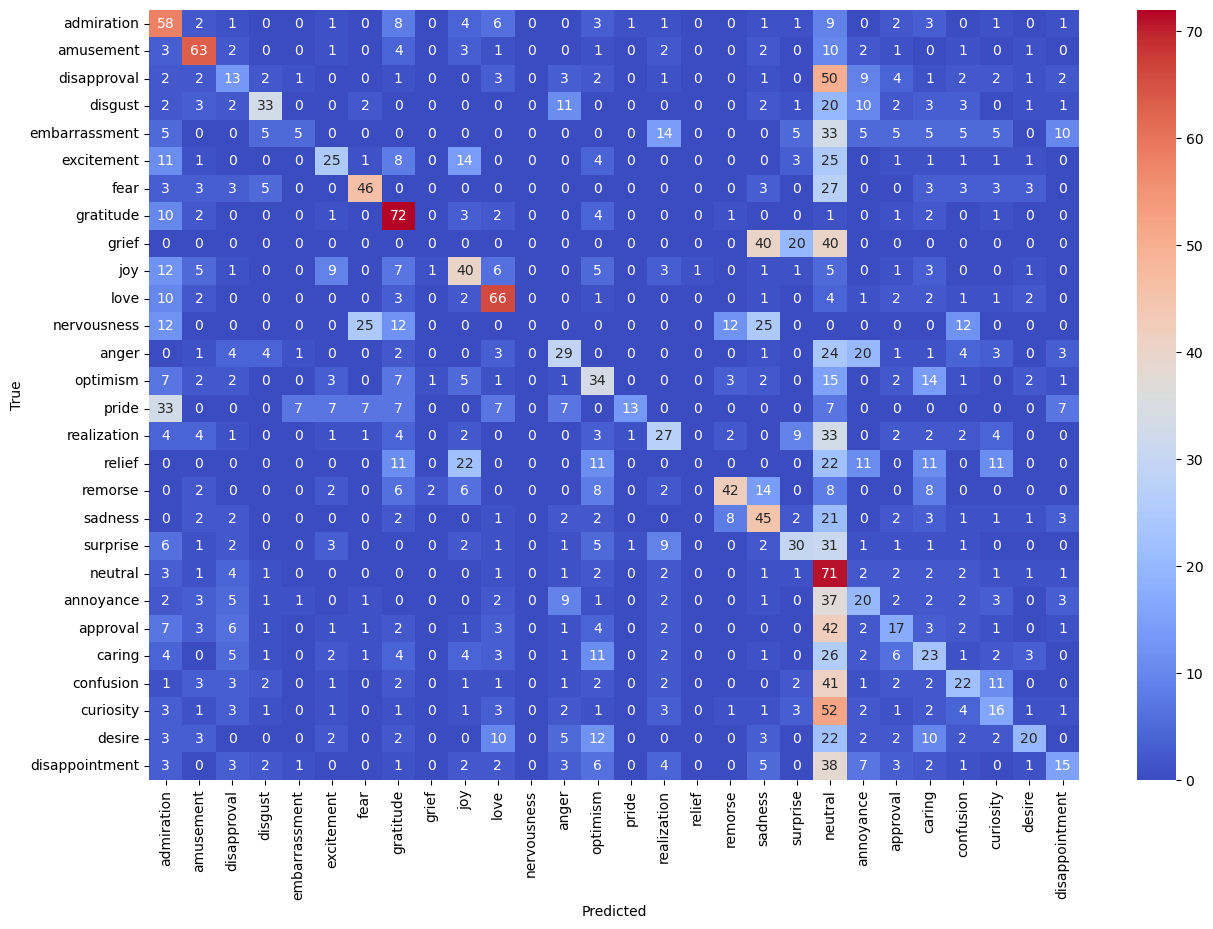

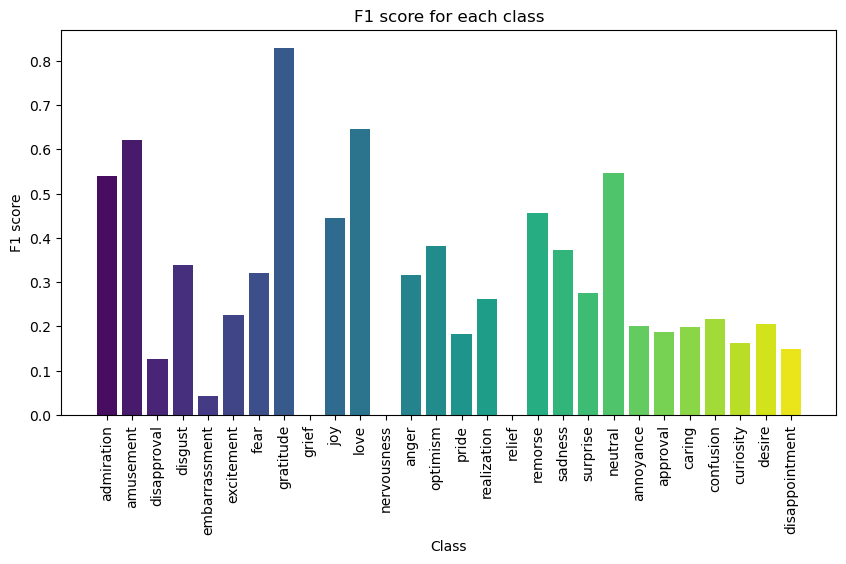

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.66                0.46                0.54                0.37                 504
amusement                           0.79                0.51                0.62                0.45                 264
disapproval                         0.20                0.09                0.13                0.07                 267
disgust                             0.60                0.24                0.34                0.20                 123
embarrassment                       0.10                0.03                0.04                0.02                  37
excitement                          0.32                0.17                0.23                0.13                 103
fear                                0.61                0.22                0.32                0.19                  78
gratitude

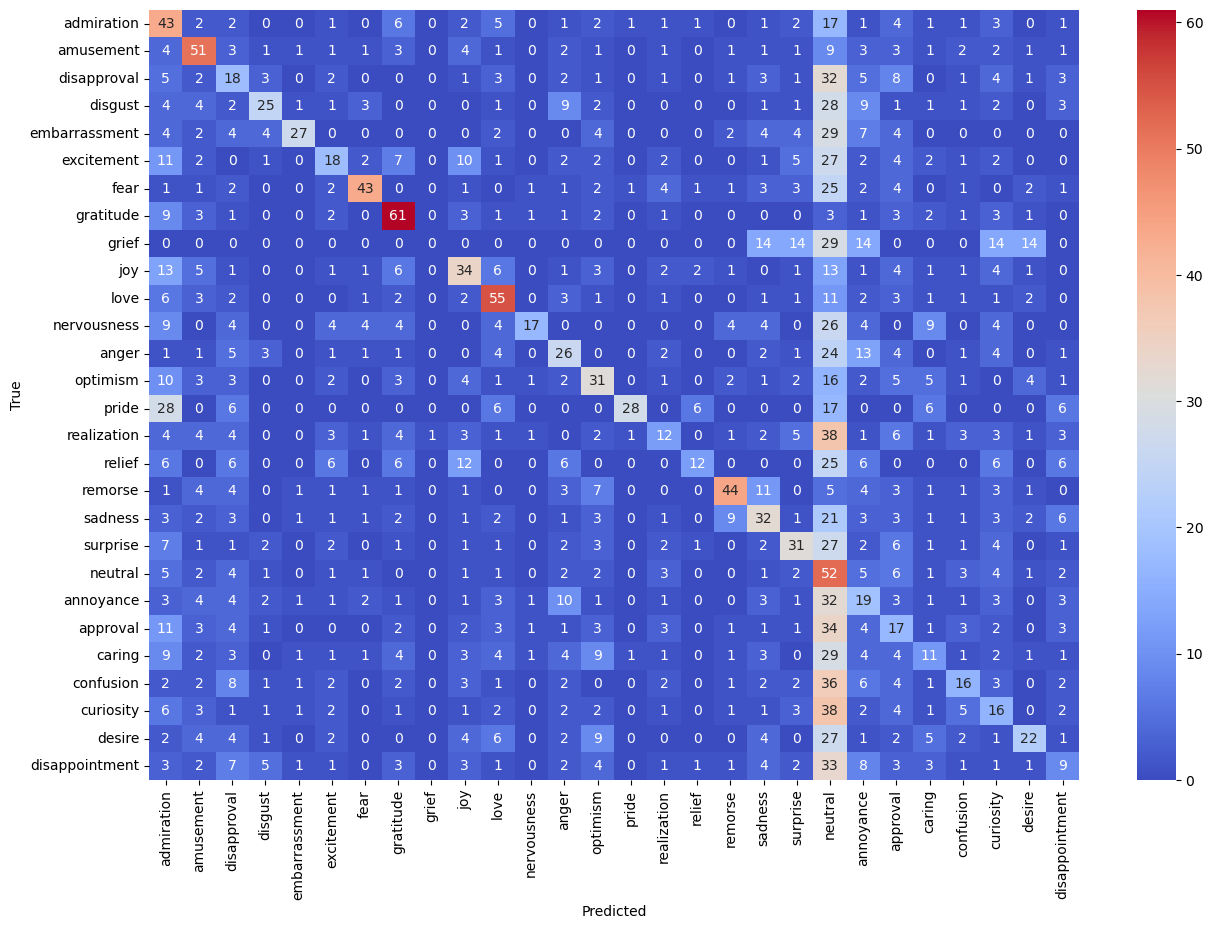

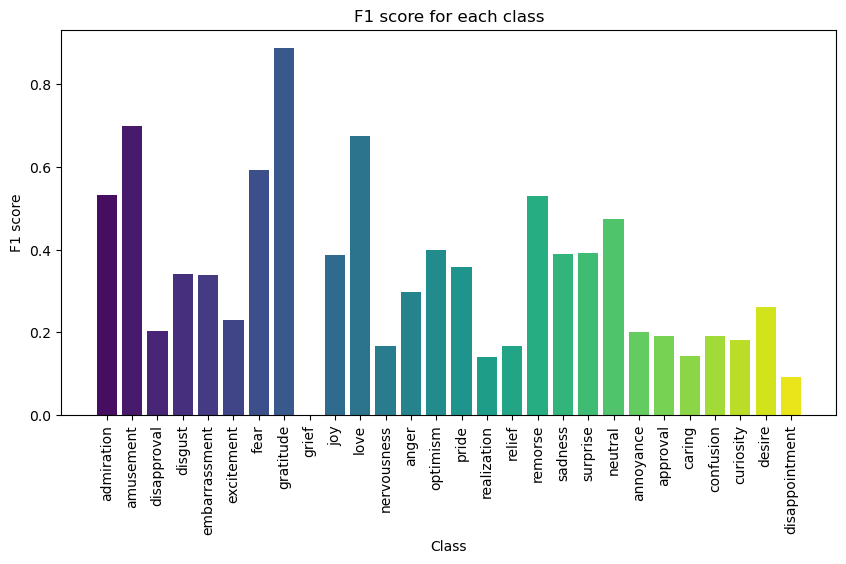

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.53                0.54                0.53                0.36                 504
amusement                           0.69                0.70                0.70                0.54                 264
disapproval                         0.22                0.19                0.20                0.11                 267
disgust                             0.44                0.28                0.34                0.20                 123
embarrassment                       0.35                0.32                0.34                0.20                  37
excitement                          0.26                0.20                0.23                0.13                 103
fear                                0.60                0.59                0.59                0.42                  78
gratitude

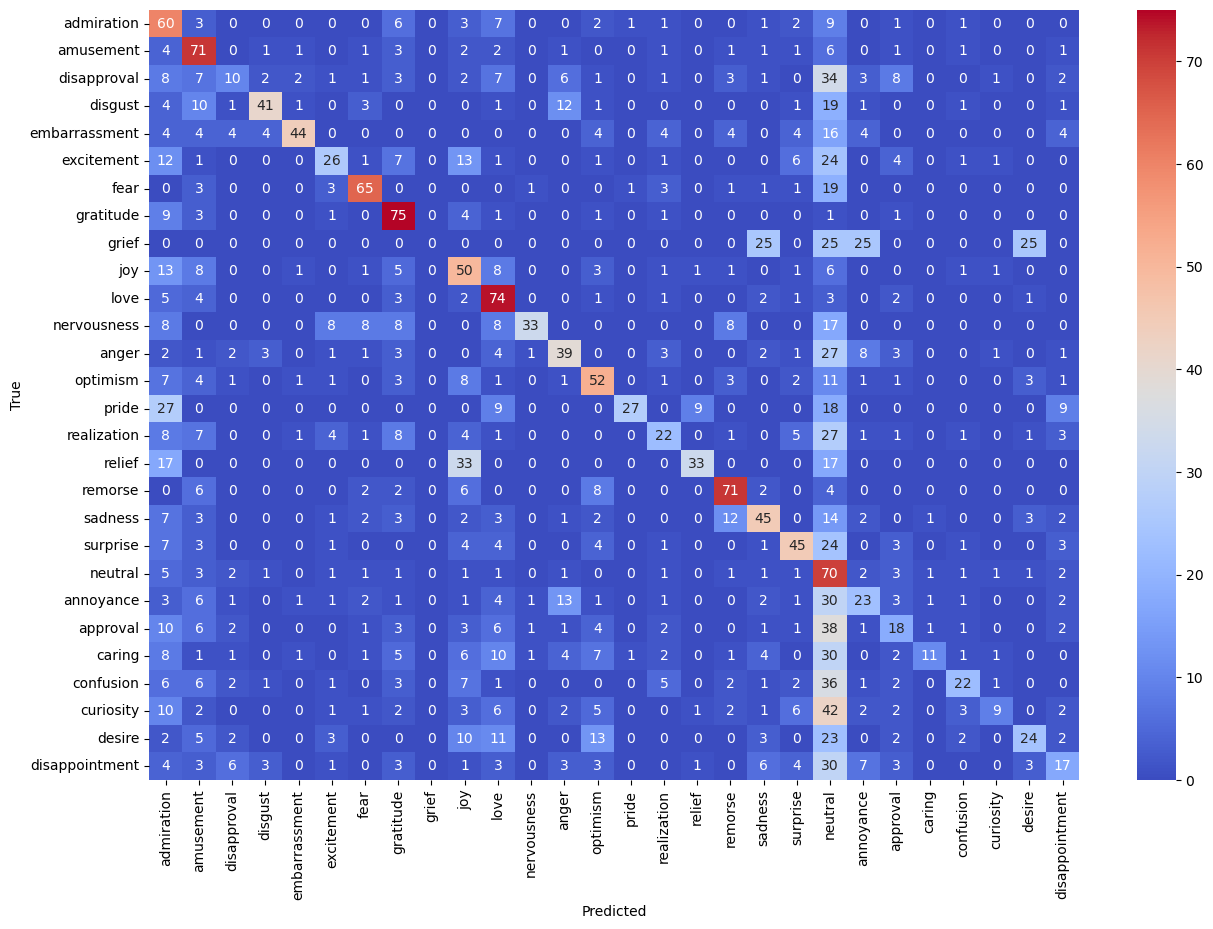

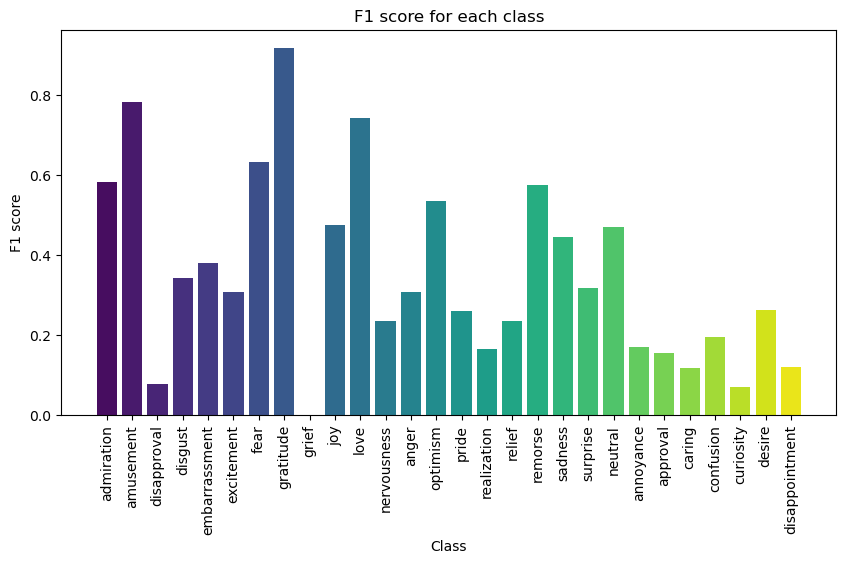

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.64                0.53                0.58                0.41                 504
amusement                           0.76                0.81                0.78                0.64                 264
disapproval                         0.27                0.04                0.08                0.04                 267
disgust                             0.70                0.23                0.34                0.21                 123
embarrassment                       0.52                0.30                0.38                0.23                  37
excitement                          0.55                0.21                0.31                0.18                 103
fear                                0.72                0.56                0.63                0.46                  78
gratitude

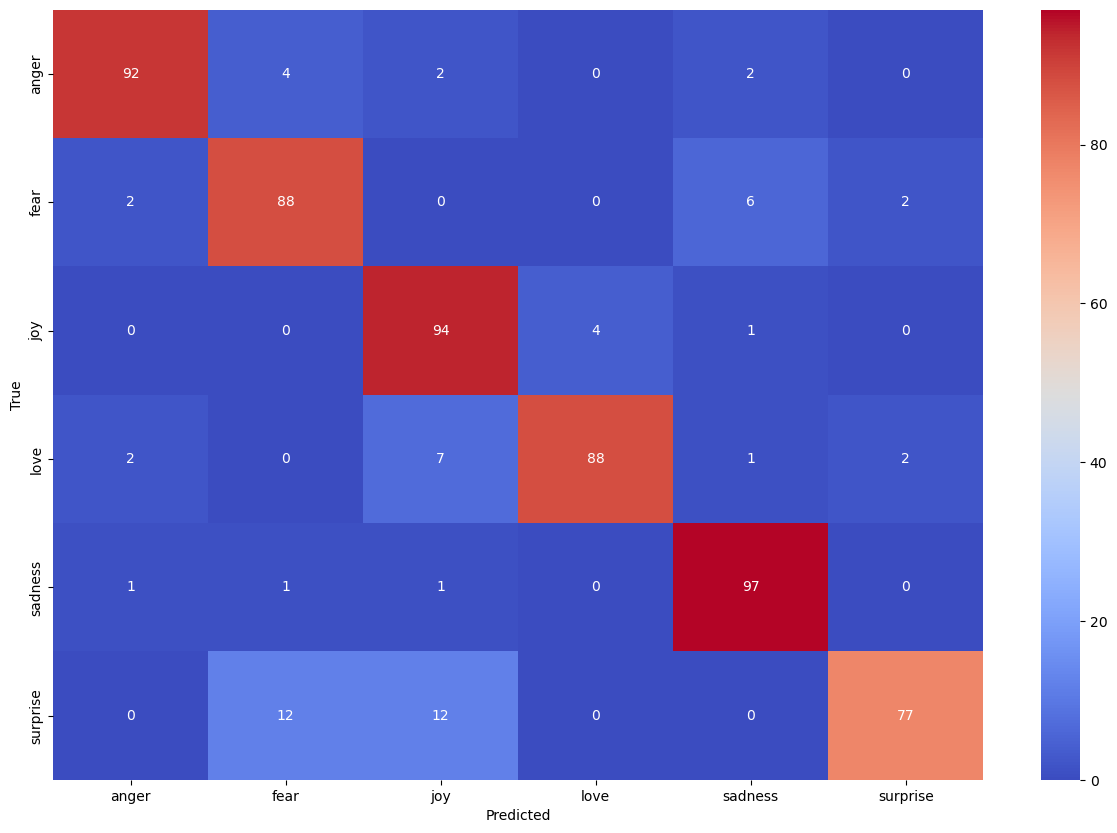

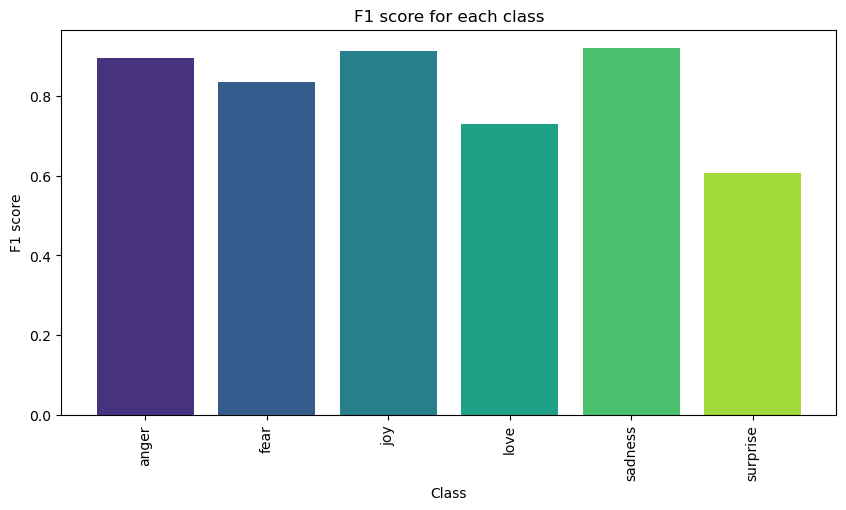

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.94                0.86                0.90                0.81                 275
fear                                0.89                0.79                0.83                0.72                 224
joy                                 0.96                0.86                0.91                0.84                 695
love                                0.80                0.67                0.73                0.58                 159
sadness                             0.96                0.89                0.92                0.85                 581
surprise                            0.77                0.50                0.61                0.43                  66
Macro avg                           0.89                0.76                0.82                0.70                2000
Micro avg

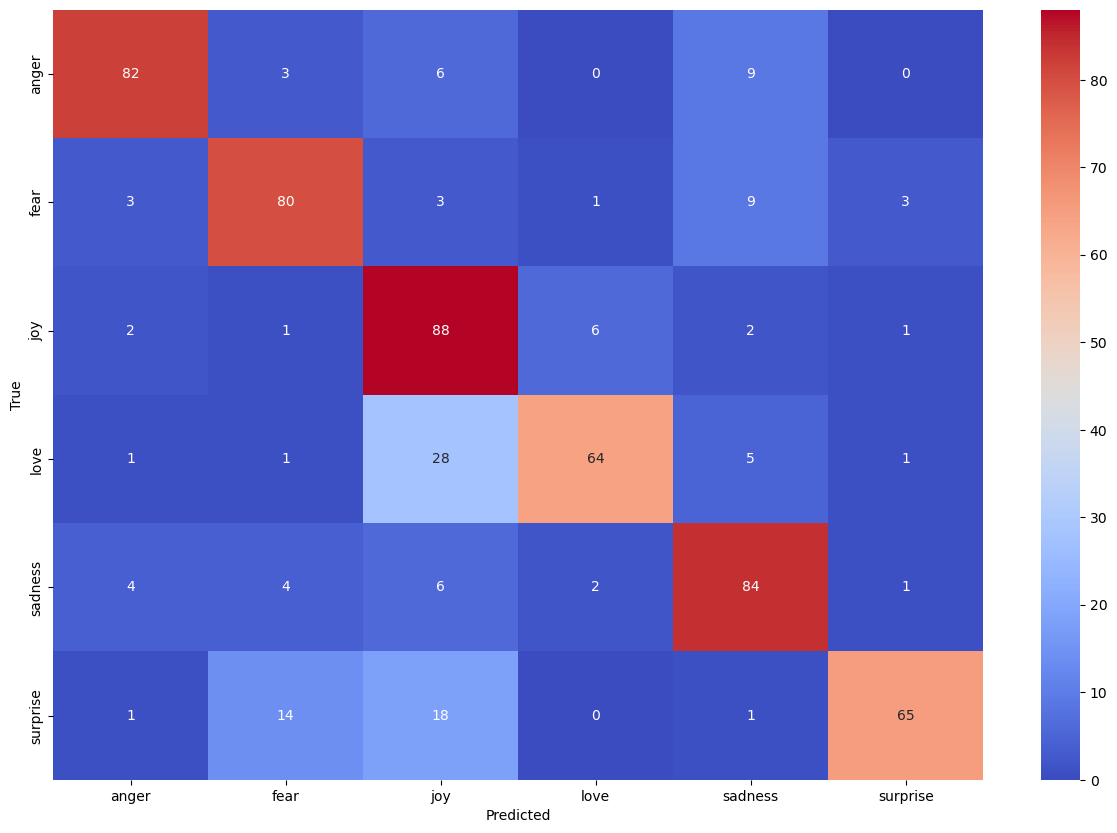

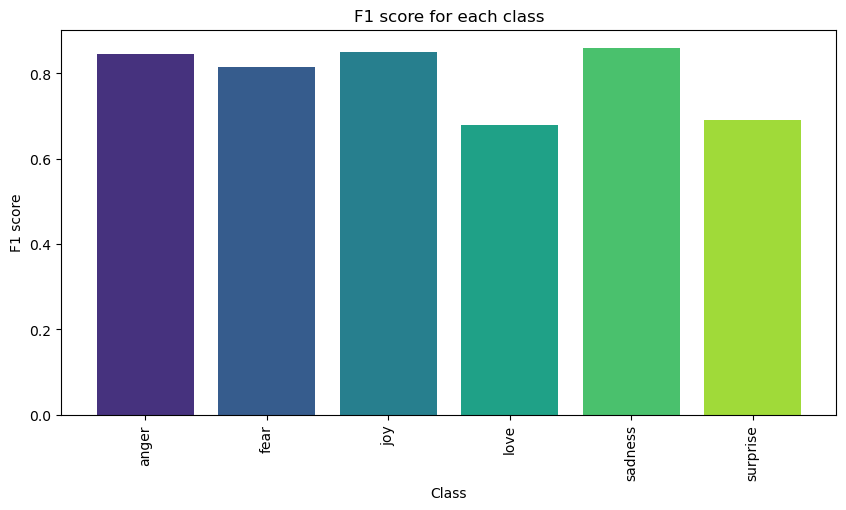

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.84                0.85                0.85                0.73                 275
fear                                0.80                0.83                0.81                0.69                 224
joy                                 0.83                0.86                0.85                0.74                 695
love                                0.67                0.69                0.68                0.51                 159
sadness                             0.87                0.85                0.86                0.75                 581
surprise                            0.67                0.71                0.69                0.53                  66
Macro avg                           0.78                0.80                0.79                0.66                2000
Micro avg

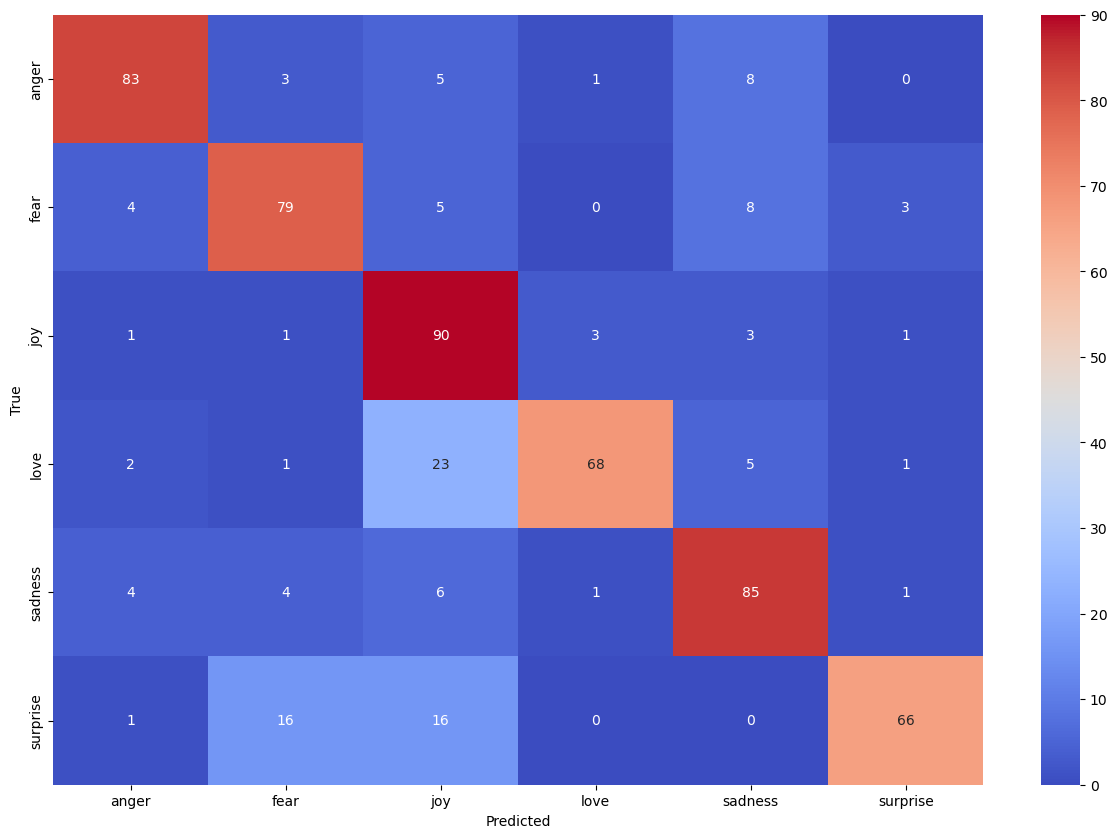

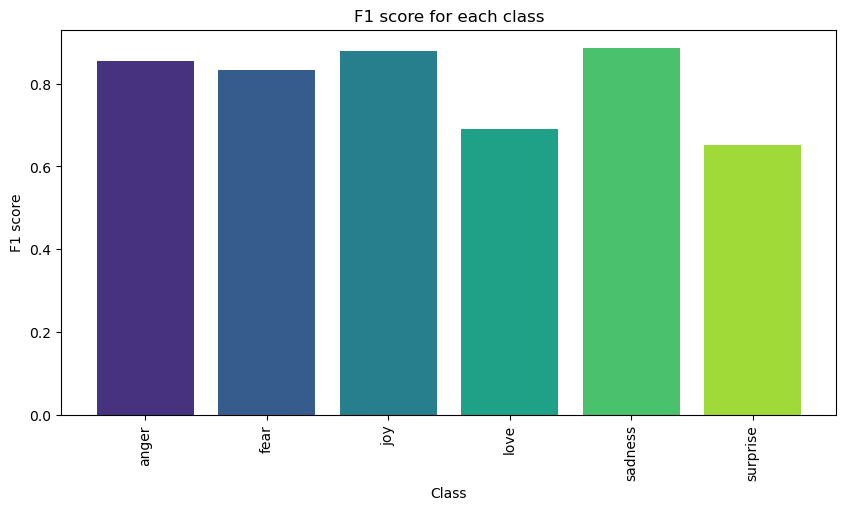

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.84                0.87                0.86                0.75                 275
fear                                0.80                0.87                0.83                0.71                 224
joy                                 0.85                0.91                0.88                0.78                 695
love                                0.74                0.64                0.69                0.53                 159
sadness                             0.88                0.89                0.89                0.80                 581
surprise                            0.64                0.67                0.65                0.48                  66
Macro avg                           0.79                0.81                0.80                0.68                2000
Micro avg

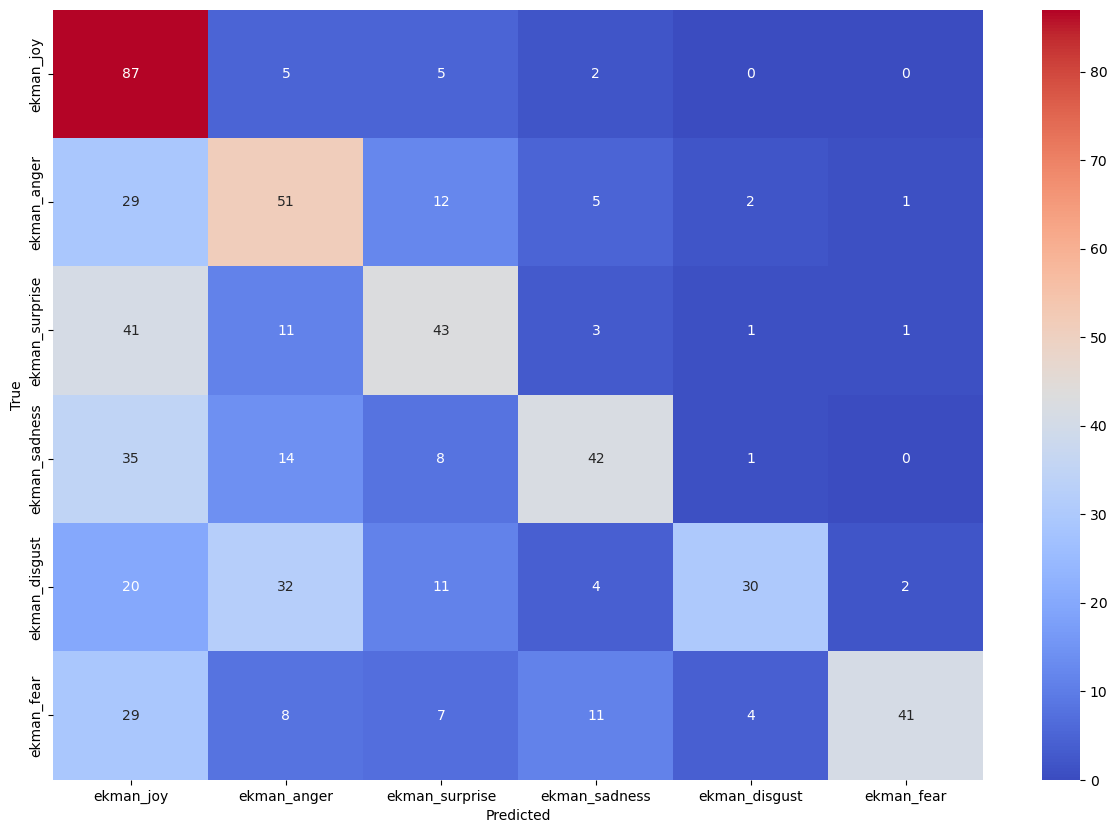

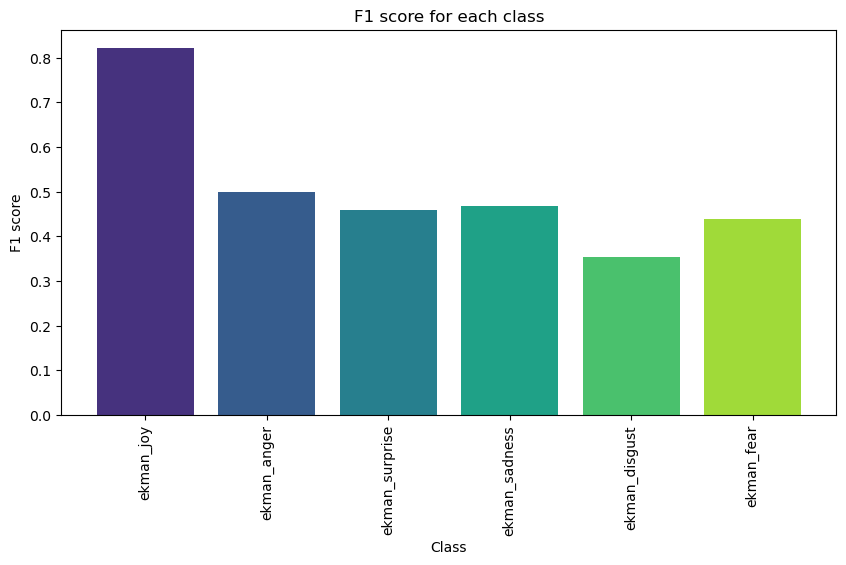

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.80                0.84                0.82                0.70                2104
ekman_anger                         0.60                0.43                0.50                0.33                 726
ekman_surprise                      0.59                0.38                0.46                0.30                 677
ekman_sadness                       0.63                0.37                0.47                0.31                 379
ekman_disgust                       0.55                0.26                0.35                0.21                 123
ekman_fear                          0.72                0.32                0.44                0.28                  98
Macro avg                           0.65                0.43                0.51                0.36                4107
Micro avg

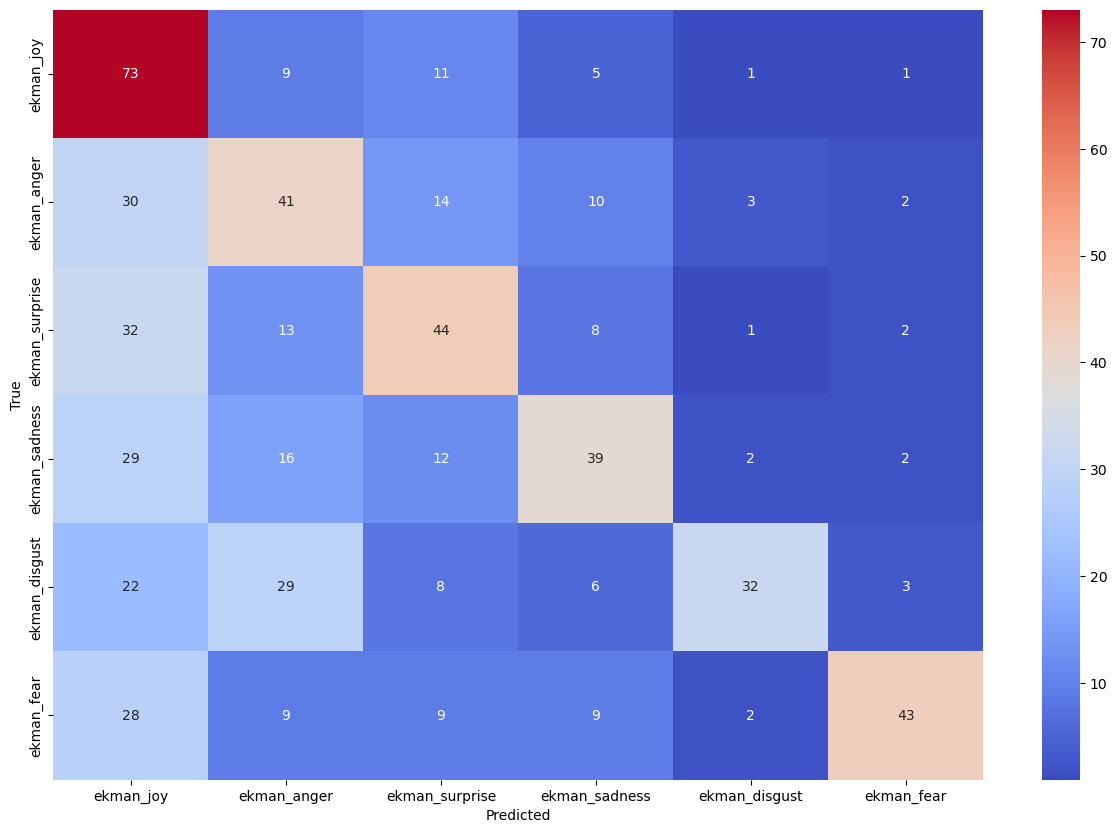

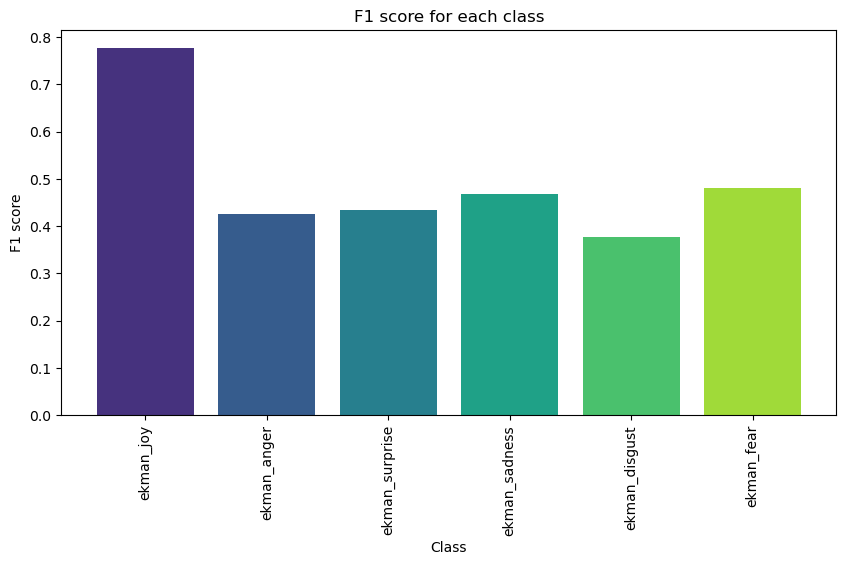

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.78                0.78                0.78                0.63                2104
ekman_anger                         0.46                0.40                0.43                0.27                 726
ekman_surprise                      0.45                0.42                0.43                0.28                 677
ekman_sadness                       0.48                0.46                0.47                0.30                 379
ekman_disgust                       0.46                0.32                0.38                0.23                 123
ekman_fear                          0.45                0.51                0.48                0.32                  98
Macro avg                           0.51                0.48                0.49                0.34                4107
Micro avg

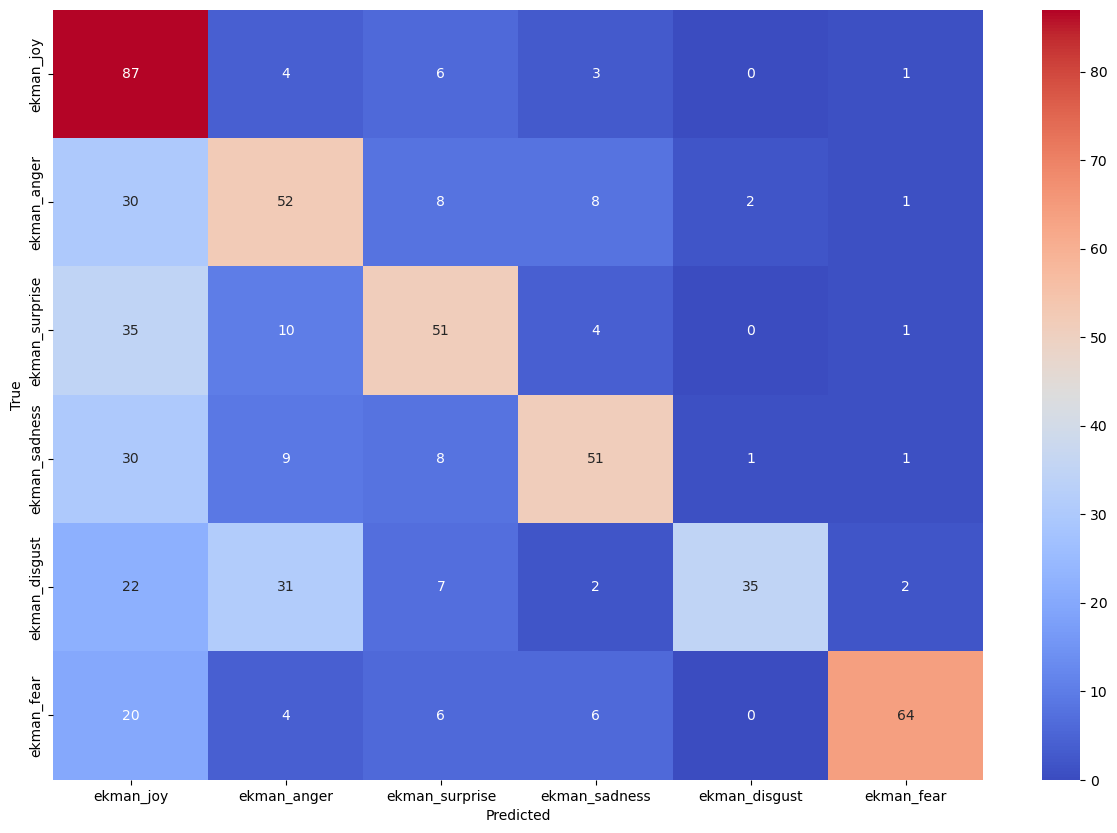

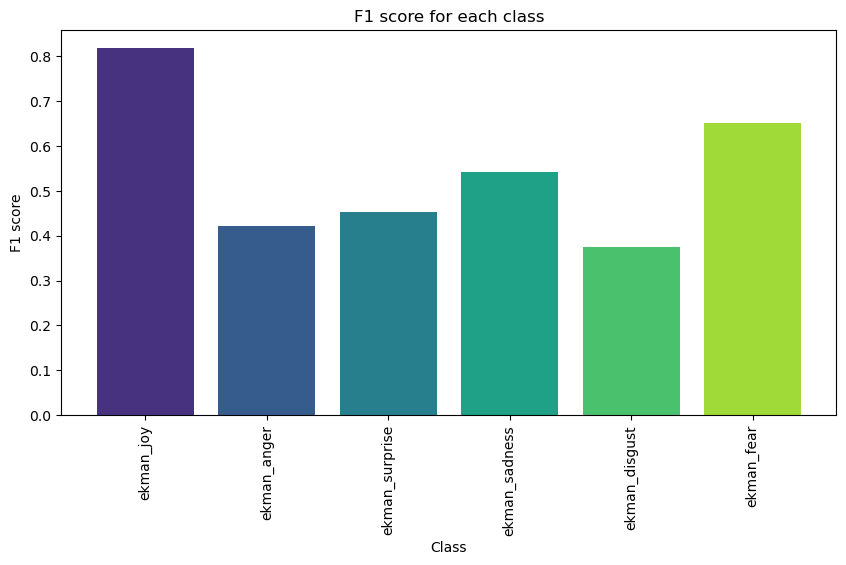

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.84                0.79                0.82                0.69                2104
ekman_anger                         0.61                0.32                0.42                0.27                 726
ekman_surprise                      0.65                0.35                0.45                0.29                 677
ekman_sadness                       0.67                0.46                0.54                0.37                 379
ekman_disgust                       0.74                0.25                0.38                0.23                 123
ekman_fear                          0.74                0.58                0.65                0.48                  98
Macro avg                           0.71                0.46                0.54                0.39                4107
Micro avg

In [5]:
# print results for all models on all datasets
all_scores = {}
for dataset in DATASETS:
    all_scores[dataset] = print_dataset_results(dataset)

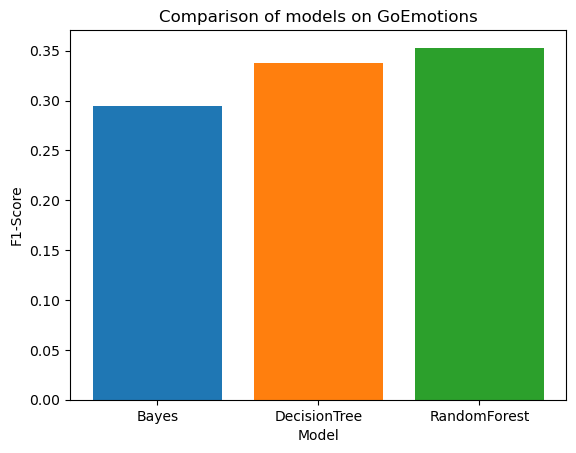

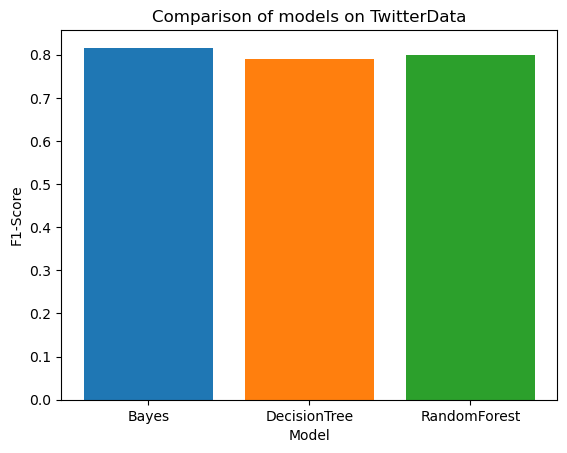

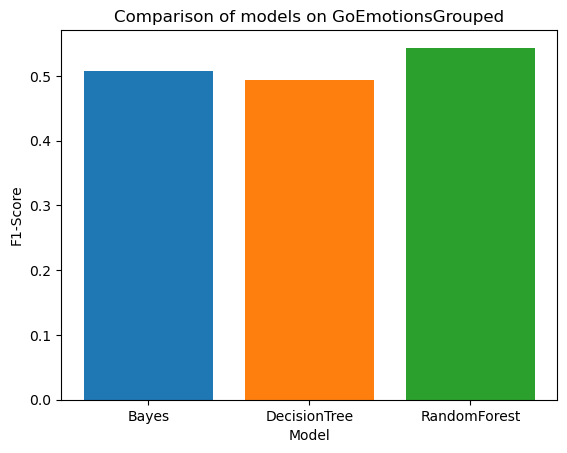

In [6]:
comparison_bar_plot(all_scores)

## Statistical testing

In [7]:
N_TESTS = 30#TODO tweak
SAMPLE_SIZE = 500
# get best model for each dataset
best_models = {}
for dataset in DATASETS:
    best_model = max(all_scores[dataset].items(), key=lambda x: x[1]['macro avg']['f1-score'])[0]
    best_models[dataset] = best_model
    # get labels
    labels = get_dataset(dataset)[2]
    labels = labels[labels.columns[1:]]
    # get best model predictions
    best_predictions = predict(best_model, dataset)
    # compare best model with all other models according to bootstrap test
    for model in MODELS:
        if model != best_model:
            # get predictions
            predictions = predict(model, dataset)
            print(f"Bootstrap test between {best_model} and {model} on {dataset}")
            bootstrap_test(best_predictions.values, predictions.values, labels, n_tests=N_TESTS, sample_size=SAMPLE_SIZE, metric_fun=f1_score, metric_name="Macro F1", metric_params={"average": "macro", "zero_division": 0})
            print("----------------------------------------------------------------------")

Bootstrap test between RandomForest and Bayes on GoEmotions
Initial Macro F1: 0.3529656914545524 0.2947884342317147
Best model: first, with delta: 0.05817725722283773
Successes: 1/30
p-value: 0.03333333333333333
----------------------------------------------------------------------
Bootstrap test between RandomForest and DecisionTree on GoEmotions
Initial Macro F1: 0.3529656914545524 0.337694987608631
Best model: first, with delta: 0.01527070384592144
Successes: 10/30
p-value: 0.3333333333333333
----------------------------------------------------------------------
Bootstrap test between Bayes and DecisionTree on TwitterData
Initial Macro F1: 0.8163722286322749 0.790014462981154
Best model: first, with delta: 0.026357765651120912
Successes: 8/30
p-value: 0.26666666666666666
----------------------------------------------------------------------
Bootstrap test between Bayes and RandomForest on TwitterData
Initial Macro F1: 0.8163722286322749 0.7991018078494245
Best model: first, with del